## Library

In [1]:
from modules.ramen_detect import *
from modules.classification import *
from modules.changeDetector import *

import matplotlib.pyplot as plt
import cv2

## Image Path

In [2]:
before_img = '/opt/ml/project/final-project-level3-cv-12/dataset/Test/rch1.jpg'
after_img = '/opt/ml/project/final-project-level3-cv-12/dataset/Test/rch2.jpg'

#### Image to Numpy

In [3]:
# import matplotlib.pyplot as plt
before_img = cv2.imread(before_img)
before_img = cv2.cvtColor(before_img, cv2.COLOR_BGR2RGB)
height, width, c = before_img.shape

after_img = cv2.imread(after_img)
after_img = cv2.cvtColor(after_img, cv2.COLOR_BGR2RGB)

## Ramen Detect By YOLOv5

In [4]:
before_bbox = ramen_detect(before_img)
after_bbox = ramen_detect(after_img)

Fusing layers... 
Model summary: 733 layers, 140035432 parameters, 0 gradients, 208.3 GFLOPs
Fusing layers... 
Model summary: 733 layers, 140035432 parameters, 0 gradients, 208.3 GFLOPs


## Change Detect

In [5]:
change_bboxes = detectChange(before_img, after_img)
change_bboxes

[(593, 489, 93, 90), (982, 164, 97, 81)]

## Ramen(Red) & Change Detect(Blue) Visualization

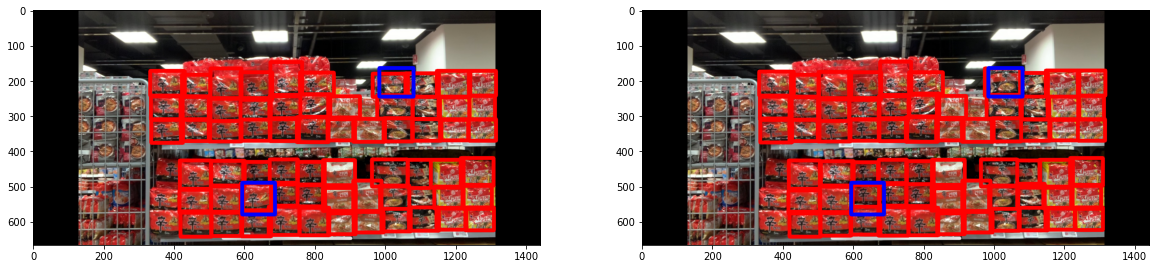

In [6]:
before_img = '/opt/ml/project/final-project-level3-cv-12/dataset/Test/rch1.jpg'
after_img = '/opt/ml/project/final-project-level3-cv-12/dataset/Test/rch2.jpg'

before_img = cv2.imread(before_img)
before_img = cv2.cvtColor(before_img, cv2.COLOR_BGR2RGB)

after_img = cv2.imread(after_img)
after_img = cv2.cvtColor(after_img, cv2.COLOR_BGR2RGB)

%matplotlib inline
f, ax = plt.subplots(ncols=2, figsize=(20, 8))

for bbox in before_bbox:
    x, y, w, h = bbox
    before_img = cv2.rectangle(before_img, (x, y), (x + w, y + h), (255, 0, 0), 10)

for bbox in after_bbox:
    x, y, w, h = bbox
    after_img = cv2.rectangle(after_img, (x, y), (x + w, y + h), (255, 0, 0), 10)

for bbox in change_bboxes:
    x, y, w, h = bbox
    before_img = cv2.rectangle(before_img, (x, y), (x + w, y + h), color = (0, 0, 255), thickness=10)
    after_img = cv2.rectangle(after_img, (x, y), (x + w, y + h), color = (0, 0, 255), thickness=10)

ax[0].imshow(before_img)
ax[1].imshow(after_img)
plt.show()

## Find Ramen Change 

In [7]:
before_ramen_change = []
for b in before_bbox:
    bx, by, bw, bh = b
    bxc = bx+bw/2
    byc = by+bh/2
    for ch in change_bboxes:
        cx, cy, cw, ch = ch
        if cx <= bxc <= cx+cw and cy <= byc <= cy+ch:
            xmin = max(bx, cx)
            ymin = max(by, cy)
            xmax = min(bx+bw, cx+cw)
            ymax = min(by+bh, cy+ch)
            area = (xmax-xmin) * (ymax-ymin)
            iou = area/(bw*bh)
            if iou >= 0.79:
                before_ramen_change.append(b)

after_ramen_change = []
for a in after_bbox:
    ax, ay, aw, ah = a
    axc = ax+aw/2
    ayc = ay+ah/2
    for ch in change_bboxes:
        cx, cy, cw, ch = ch
        if cx <= axc <= cx+cw and cy <= ayc <= cy+ch:
            xmin = max(ax, cx)
            ymin = max(ay, cy)
            xmax = min(ax+aw, cx+cw)
            ymax = min(ay+ah, cy+ch)
            area = (xmax-xmin) * (ymax-ymin)
            iou = area/(aw*ah)
            if iou >= 0.79:
                after_ramen_change.append(a)

In [8]:
before_ramen_change.sort(), after_ramen_change.sort()
before_ramen_change, after_ramen_change

([[589, 491, 88, 78], [963, 180, 100, 66]],
 [[593, 492, 80, 65], [972, 165, 100, 78]])

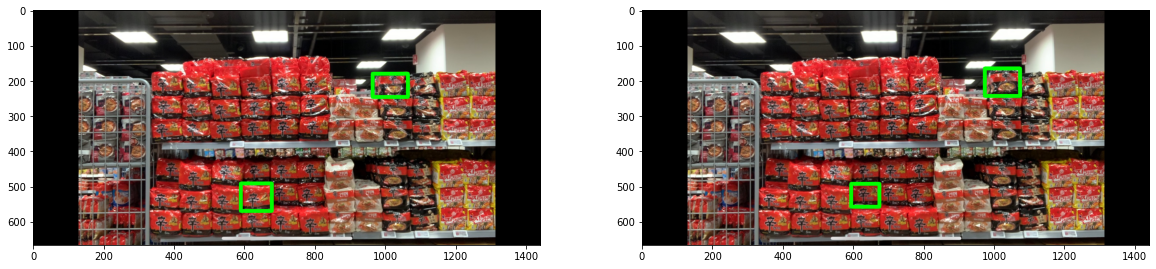

In [9]:
before_img = '/opt/ml/project/final-project-level3-cv-12/dataset/Test/rch1.jpg'
after_img = '/opt/ml/project/final-project-level3-cv-12/dataset/Test/rch2.jpg'

before_img = cv2.imread(before_img)
before_img = cv2.cvtColor(before_img, cv2.COLOR_BGR2RGB)

after_img = cv2.imread(after_img)
after_img = cv2.cvtColor(after_img, cv2.COLOR_BGR2RGB)

%matplotlib inline
f, ax = plt.subplots(ncols=2, figsize=(20, 8))

for bbox in before_ramen_change:
    x, y, w, h = bbox
    before_img = cv2.rectangle(before_img, (x, y), (x + w, y + h), (0, 255, 0), 10)

for bbox in after_ramen_change:
    x, y, w, h = bbox
    after_img = cv2.rectangle(after_img, (x, y), (x + w, y + h), (0, 255, 0), 10)


ax[0].imshow(before_img)
ax[1].imshow(after_img)
plt.show()

In [10]:
before_change_label = Classifier().get_label(img=before_img, bboxes=before_ramen_change)
after_change_label = Classifier().get_label(img=after_img, bboxes=after_ramen_change)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [11]:
before_change_label, after_change_label

(['농심_신라면', '농심_신라면블랙'], ['농심_신라면', '농심_신라면블랙'])

#### before와 after change box 위치가 같을 경우 bbox 넓이로만 계산

In [12]:
variation = [] 

## iou 고려?
for i in range(len(before_ramen_change)):
    before_area = before_ramen_change[i][2] * before_ramen_change[i][3]
    after_area = after_ramen_change[i][2] * after_ramen_change[i][3]
    
    if before_area >= after_area:
        variation.append(-1)
    else:
        variation.append(1)

for i in range(len(before_change_label)):
    print(f'after ramen{i+1} :',before_change_label[i], 'change :', variation[i])

after ramen1 : 농심_신라면 change : -1
after ramen2 : 농심_신라면블랙 change : 1
